# Inference on EEG data using CNN techniques

run this in your terminal window

```
pip install tensorflow
```

and then run

```
pip install mne 
```

Add required dependencies and download dataset using json

In [1]:
import os
import json
import matplotlib.pyplot as plt
from mne.datasets import eegbci
import mne 
import numpy as np
import pandas as pd
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch



Download the file - Adjust mne_config if runnung this file locally

In [2]:
mne_config_dir = os.path.expanduser("~/.mne")
os.makedirs(mne_config_dir, exist_ok=True)

# Write the config JSON file
mne_config = {
    "MNE_DATA": "/Users/jpxmaestas/mne_data"
}
with open(os.path.join(mne_config_dir, "mne-python.json"), "w") as f:
    json.dump(mne_config, f)

### Respond 'y' to the following block below

In [3]:
sample_frequency = 50
subject = 2 
runs = [6, 10, 14]
raw_fnames = eegbci.load_data(subject, runs)

raw = mne.io.read_raw_edf(raw_fnames[0], preload=True)
for fname in raw_fnames[1:]:
    raw.append(mne.io.read_raw_edf(fname, preload=True))

Extracting EDF parameters from /Users/jpxmaestas/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /Users/jpxmaestas/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /Users/jpxmaestas/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


### Converting raw file to MNE file

In [20]:
# Bandpass filter the data (typical for motor imagery)
raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')

# Extract events from annotations
events, _ = mne.events_from_annotations(raw)

# Define motor imagery classes: left = 2, right = 3
event_id = dict(left=2, right=3)

# Create epochs (4s trials starting at event onset)
epochs = mne.Epochs(
    raw, events, event_id, tmin=0., tmax=4., baseline=None,
    reject_by_annotation=False, preload=True
)

# Extract the data and labels
X = epochs.get_data()  # shape: (n_trials, n_channels, n_times)
y = epochs.events[:, -1]

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 641 original time points ...
0 bad epochs dropped


Transform y to classification Values

$$2 \to 0$$

$$3 \to 1$$

So, now y is an indicator random variable where if right hand motor activity is monitored, it maps to one

In [21]:
y = pd.Series(epochs.events[:, -1]) 
print(np.unique(y))
y = y.map({2: 0, 3: 1, 4: 2}).values
print(np.unique(y))

[2 3]
[0 1]


# EDA

Now, we need to process and visualize the data in order to make better inference on which.

In [6]:
# Pick channel name (e.g., 'C3..' or 'C3' after renaming)
channel = 'all'
channel_c4 = 'data'
data, times = raw.copy().pick(channel).get_data(return_times=True)

import pandas as pd

# data has shape (1, n_times) — so take the first row
df = pd.DataFrame({
    'time': times,
    channel: data[0]
})



events, _ = mne.events_from_annotations(raw)
# Convert sample indices to time (in seconds)
event_times_in_seconds = events[:, 0] / raw.info['sfreq']


Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]


Plot raw eeg data ($\mu\text{V}$ vs time (s))

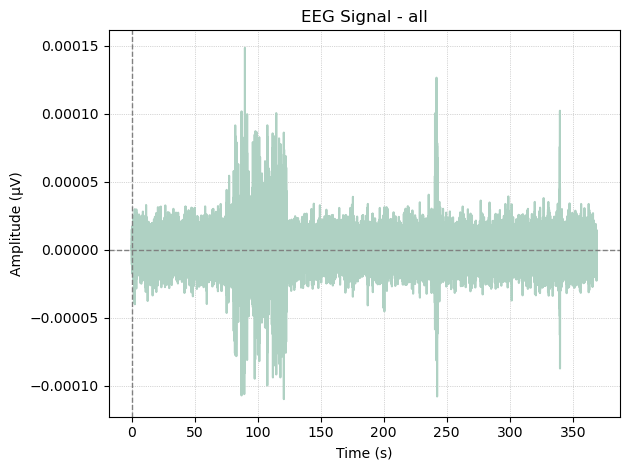

In [7]:
window_size = 100
plt.plot(df['time'], df[channel],color='#afd1c3')
plt.title(f"EEG Signal - {channel}")


plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)

# Add horizontal line at amplitude = 0
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)

plt.xlabel("Time (s)")
plt.ylabel("Amplitude (μV)")
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

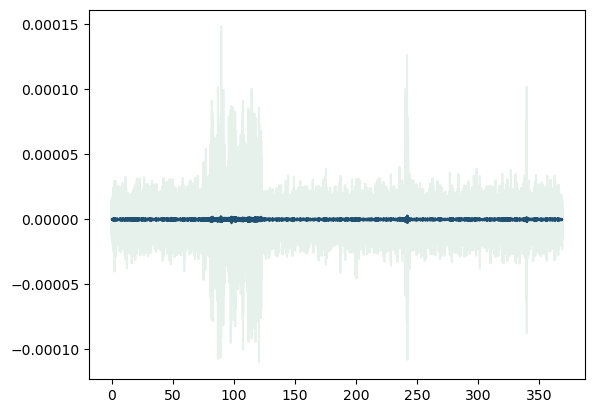

In [8]:
df['smoothed'] = df[channel].rolling(window=window_size, center=True).mean()

plt.plot(df['time'], df[channel], color='#afd1c3', alpha=0.3, label='Raw')
plt.plot(df['time'], df['smoothed'], color='#205072', linewidth=1.5, label='Smoothed')

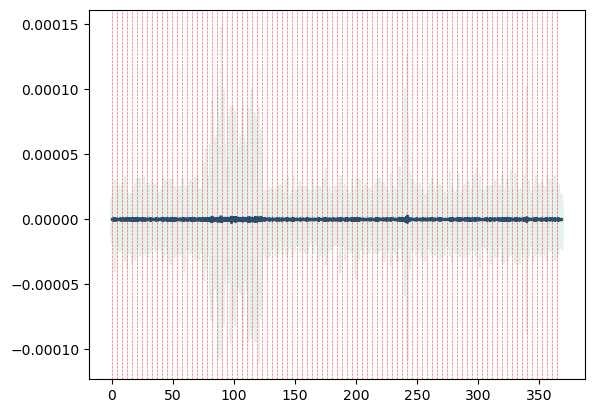

In [9]:
window_size = 100  # Adjust based on sampling rate
df['smoothed'] = df[channel].rolling(window=window_size, center=True).mean()

plt.plot(df['time'], df[channel], color='#afd1c3', alpha=0.3, label='Raw')
plt.plot(df['time'], df['smoothed'], color='#205072', linewidth=1.5, label='Smoothed')
for onset in event_times_in_seconds:
    plt.axvline(x=onset, color='red', linestyle='--', linewidth=0.5, alpha=0.6)

Mark by Epoch

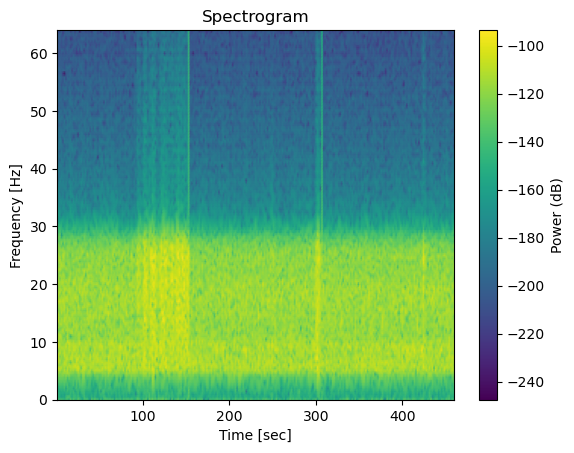

In [10]:
from scipy.signal import spectrogram

f, t, Sxx = spectrogram(df[channel], fs=128)  # Adjust sampling rate
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud', cmap='viridis')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram')
plt.colorbar(label='Power (dB)')


This visualization is very iportant for visualizing brain activity. Since the highest power is recorded between approx. 5 and 30, then We can determine the subject is in an active state of attentiveness.

| Wave Category   | Frequency Range    |  Associated Mental Activity | 
| --------------- | ------------------ | --------------------------- | 
| Delta           | Less than 4 Hz     | Unconsciousness             | 
| Theta           | 4 to 8 Hz          | Relaxation - early stages of sleep| 
| Alpha           | 8 to 12 Hz.        | Focused                 | 
| Beta            | 13-30 Hz           | Alertness - active problem solving | 
| Gamma           | Greater than 30 Hz | Focused information processing - higher level functions | 


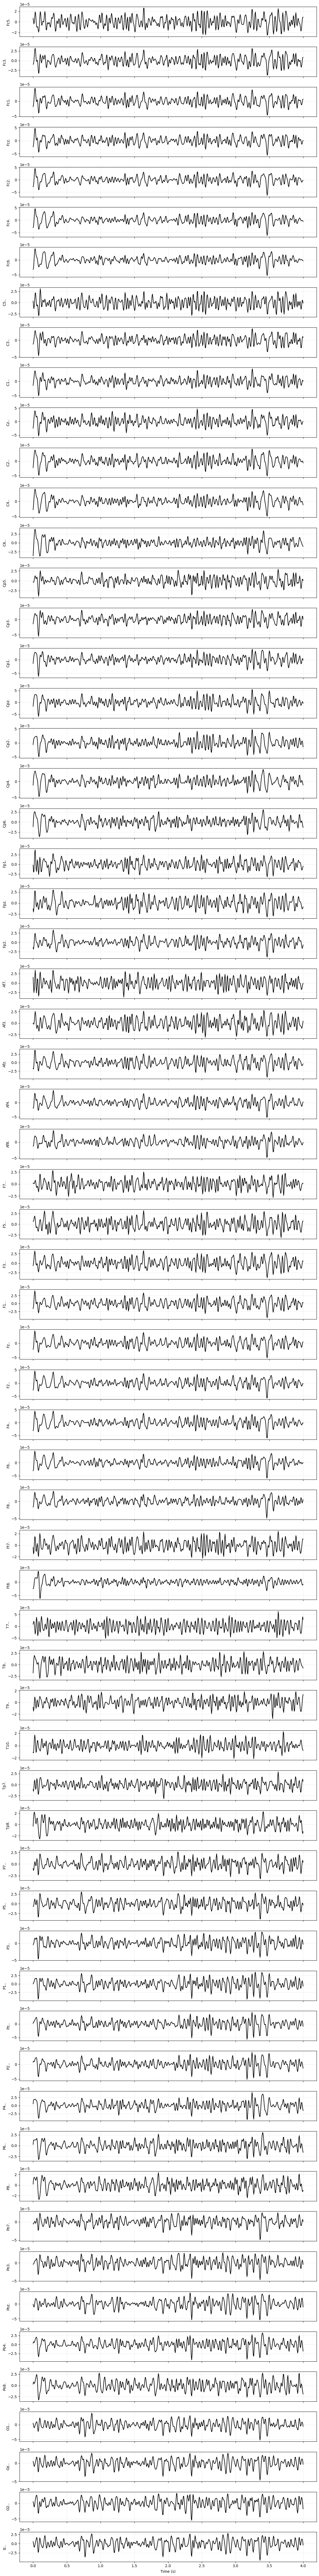

In [11]:
channel_names = epochs.ch_names  # or raw.ch_names if using raw data
n_channels = len(channel_names)

fig, axs = plt.subplots(n_channels, 1, figsize=(12, n_channels * 1.5), sharex=True)

for i in range(n_channels):
    axs[i].plot(np.linspace(0, 4, X.shape[2]), X[0, i, :], color='black')
    axs[i].set_ylabel(channel_names[i])
    axs[i].grid(True, linestyle=':', linewidth=0.5)

axs[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()


We have now seperated the signal with respect to the channels. Each channel represents a unique placement of an electrode. The channel which we are most interested in for the purpose of this CNN is ....

| Code            | Brain Region       | 
| --------------- | ------------------ | 
| **Fp**          | Frontopolar        | 
| **F**           | Frontal            | 
| **AF**          | Anterior Frontal   | 
| **FC**          | Fronto-Central     | 
| **C**           | Central            | 
| **CP**          | Centro-Parietal    | 
| **P**           | Parietal           |
| **PO**          | Parieto-Occipital  | 
| **O**           | Occipital          |
| **T / FT / TP** | Temporal           | 
| **Fz, Cz, Pz**  | Midline electrodes |


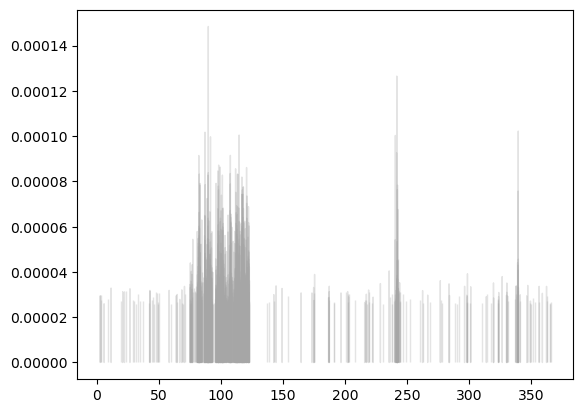

In [12]:
threshold = df[channel].std() * 2
channel_names = [ch.replace('.', '') for ch in epochs.ch_names]
plt.fill_between(df['time'], df[channel], where=(df[channel] > threshold), color='#A6A6A6', alpha=0.3)

# Processing

Raw EEG data is special in that we need to slice it into fixed length segments known as epochs. The purpose of which is to process the action of motor activity.

In [13]:
from mne import Epochs, events_from_annotations
events, _ = events_from_annotations(raw)
event_id = dict(left=2, right=3)  # use appropriate IDs

epochs = Epochs(raw, events, event_id=event_id, tmin=0., tmax=4.,
                baseline=None, preload=True, reject_by_annotation=False)

Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 641 original time points ...
0 bad epochs dropped


The Epochs module has denoted within intervals of 4 seconds, there are 45 neurological events

In [14]:
X = epochs.get_data()  # shape: (n_epochs, n_channels, n_times)
#y = pd.Series(epochs.events[:, -1])  # Labels (e.g., 2 = left, 3 = right)

In [15]:
X = (X - X.mean(axis=(1, 2), keepdims=True)) / X.std(axis=(1, 2), keepdims=True)
print(X.shape)

(45, 64, 641)


Epochs v.s. Channels

# Processing (II) - Convolution Layer

Similar to image training, we need to process the data by Convolution followed by ReLU activation

In [16]:
from torch.utils.data import TensorDataset, DataLoader
import torch

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor((y == 3).astype(int), dtype=torch.long)  # right = 1, left = 0
dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

## Processing (II) - Apply ReLU function 

$$\text{ReLU(x)} = \begin{cases} x \quad x > 0\\ 0 \quad x < 0\end{cases}$$

Now, We will pool the data 

In [ ]:

class EEGNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(X.shape[1], 16, kernel_size=5)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.LazyLinear(2)  # Adapts to input size on first use

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        return self.fc1(x)


EDIT

In [ ]:
model = EEGNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    for xb, yb in train_loader:
        out = model(xb)
        loss = criterion(out, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 1, Loss: 0.0526
Epoch 2, Loss: 0.0005
Epoch 3, Loss: 0.0000
Epoch 4, Loss: 0.0000
Epoch 5, Loss: 0.0000
Epoch 6, Loss: 0.0000
Epoch 7, Loss: 0.0000
Epoch 8, Loss: 0.0000
Epoch 9, Loss: 0.0000
Epoch 10, Loss: 0.0000


In [19]:
correct = 0
total = 0
with torch.no_grad():
    for xb, yb in train_loader:
        outputs = model(xb)
        _, predicted = torch.max(outputs, 1)
        total += yb.size(0)
        correct += (predicted == yb).sum().item()
print(f"Training Accuracy: {100 * correct / total:.2f}%")

Training Accuracy: 100.00%
